In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
import warnings
import string
import re
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, roc_curve, classification_report, confusion_matrix, precision_recall_curve, auc

In [3]:
data = pd.read_csv('data/news_political_dataset.csv')
assert data.shape == tuple([69505, 3])
data.sample(5)

,headline,short_description,is_political
59005,"Aiguille Du Midi Offers Epic, Thrilling Views ...",Aiguille du Midi has long been a destination f...,0
29908,Madonna Speaks Out After Widely Panned Prince ...,Questlove also defended the singer's performance.,0
8228,The Poultry Lobby Wants Trump To Let Them Spee...,Labor and safety groups are urging the Agricul...,1
31786,See All The Winners From The MTV Movie Awards ...,Because the anticipation was killing you.,0
65216,10 Family Adventures In Latin America (PHOTOS),Help herd sheep with the gauchos on the Patago...,0


In [39]:
def clf_model(model_type, X_train, y_train, X_valid):
    model = model_type.fit(X_train,y_train)
    predicted_labels = model.predict(X_valid)
    predicted_probab = model.predict_proba(X_valid)[:,1]
    assert len(predicted_labels) == len(predicted_probab) == X_valid.shape[0]
    return [predicted_labels,predicted_probab, model]

In [40]:
def model_evaluation(actual_values, predicted_values, predicted_probabilities):
    assert len(actual_values) == len(predicted_values) == len(predicted_probabilities)
    cfn_mat = confusion_matrix(actual_values,predicted_values)
    print("confusion matrix: \n",cfn_mat)
    print("\naccuracy: ",accuracy_score(actual_values,predicted_values))
    print("\nclassification report: \n", classification_report(actual_values,predicted_values))
    fpr,tpr,threshold=roc_curve(actual_values, predicted_probabilities)
    print ('\nArea under ROC curve for validation set:', auc(fpr,tpr))
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(fpr,tpr,label='Validation set AUC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    ax.legend(loc='best')
    plt.show()

In [41]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
stop_words = stop_words + list(string.printable)
data['cleaned_headline_text'] = data['short_description'].apply(\
lambda x : ' '.join([lemmatizer.lemmatize(word.lower()) \
    for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x))) if word.lower() not in stop_words]))

In [49]:
MAX_FEATURES = 200
tfidf_model = TfidfVectorizer(max_features=MAX_FEATURES)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(data['cleaned_headline_text']).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
assert (tfidf_df!=0).any().all()
tfidf_df.head()

,10,administration,already,also,always,america,american,another,around,away,...,white,win,without,woman,work,world,would,year,yet,york
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(tfidf_df, data['is_political'], test_size=0.2, random_state=42,stratify = data['is_political'])

confusion matrix: 
 [[6862  491]
 [3498 3050]]

accuracy:  0.7130422271779009

classification report: 
               precision    recall  f1-score   support

           0       0.66      0.93      0.77      7353
           1       0.86      0.47      0.60      6548

    accuracy                           0.71     13901
   macro avg       0.76      0.70      0.69     13901
weighted avg       0.76      0.71      0.69     13901


Area under ROC curve for validation set: 0.7499565605185604


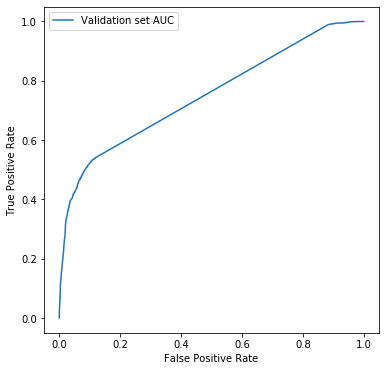

In [44]:
from xgboost import XGBClassifier
xgb_clf=XGBClassifier(n_estimators=10,learning_rate=0.05,max_depth=18,subsample=0.6,colsample_bytree= 0.6,reg_alpha= 10,seed=42)
results = clf_model(xgb_clf, X_train, y_train, X_valid)
model_evaluation(y_valid, results[0], results[1])
model_xgb = results[2]

In [47]:
word_importances = pd.DataFrame({'word':X_train.columns,'importance':model_xgb.feature_importances_})
assert word_importances.shape == tuple([MAX_FEATURES, 2])
word_importances.sort_values('importance', ascending = False).head(4)

,word,importance
178,trump,0.192977
136,president,0.093427
144,republican,0.070339
25,clinton,0.043241
